In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.resnet50 import preprocess_input
import cv2
from tqdm import tqdm

In [13]:
def build_model(model_dir):
    # Load base model and extract both feature maps and predictions
    model = tf.keras.models.load_model(model_dir)
    feature_maps = model.layers[-2].output
    predictions = model.output

    # Build a new model returning both outputs
    model = tf.keras.models.Model(inputs=model.input, outputs=[feature_maps, predictions])
    return model


def load_and_preprocess_image(path, target_size=(224, 224)):
    image = load_img(path, target_size=target_size)
    image = np.array(image)
    preprocessed = preprocess_input(image[np.newaxis, ...])
    return image, preprocessed


def compute_gradcam_heatmap(preprocessed_image, model):
    # Grad-CAM: compute class-specific gradients over feature maps
    with tf.GradientTape() as tape:
        feature_maps, preds = model(preprocessed_image, training=False)
        tape.watch(feature_maps)
        top_class = tf.argmax(preds[0])
        top_class_score = preds[:, top_class]

    grads = tape.gradient(top_class_score, feature_maps)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0,1))
    feature_maps = feature_maps[0]

    heatmap = tf.reduce_sum(feature_maps * pooled_grads, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return cv2.resize(heatmap, (224,224))


@tf.custom_gradient
def guided_relu(x):
    # Guided ReLU: only allow positive gradients/activations
    def grad(dy):
        return tf.cast(dy > 0, "float32") * tf.cast(x > 0, "float32") * dy
    return tf.nn.relu(x), grad


class GuidedBackprop:
    def __init__(self, model):
        # Rebuild model replacing all ReLUs with Guided ReLU
        self.model = model
        self.gb_model = self.build_guided_model()

    def build_guided_model(self):
        gb_model = tf.keras.Model(self.model.inputs, self.model.output[1])
        for layer in [l for l in gb_model.layers[1:] if hasattr(l, "activation")]:
            if layer.activation == tf.keras.activations.relu:
                layer.activation = guided_relu
        return gb_model

    def guided_backprop(self, preprocessed_image: np.ndarray):
        with tf.GradientTape() as tape:
            inputs = tf.cast(preprocessed_image, tf.float32)
            tape.watch(inputs)
            outputs = self.gb_model(inputs)
        return tape.gradient(outputs, inputs)[0]


def add_gaussian_noise(image, mean=0.0, stddev=5.0):
    # Add clipped Gaussian noise to image (keeps range [0,255])
    image = tf.cast(image, tf.float32)
    noise = tf.random.normal(tf.shape(image), mean=mean, stddev=stddev, dtype=tf.float32)
    return tf.clip_by_value(image + noise, 0.0, 255.0)


def generate_smooth_guided_gradcam(model, image, guided_model, gradcam_map, n_samples=20, stddev=5.0):
    """
    Smooth Guided GradCAM: average Guided Backprop maps over noisy inputs,
    weighted by GradCAM map.
    """
    guided_grads_list = []
    for _ in tqdm(range(n_samples), "Iterating N times adding noise..."):
        noisy = add_gaussian_noise(image, stddev=stddev)
        grads = guided_model.guided_backprop(noisy)
        combined = grads * np.repeat(gradcam_map[..., np.newaxis], 3, axis=2)
        guided_grads_list.append(combined)

    smooth_guided_gradcam = tf.reduce_mean(guided_grads_list, axis=0)
    return 1 - calibrate_saliency_range(smooth_guided_gradcam)


def calibrate_saliency_range(saliency_map, base_gray=0.2, contrast_factor=0.7):
    # Normalize and enhance saliency map for better visualization
    if saliency_map.ndim == 3:
        saliency_map = np.array(saliency_map).mean(axis=-1)
    saliency_map = np.clip(saliency_map, np.percentile(saliency_map, 5), np.percentile(saliency_map, 95))
    saliency_normalized = (saliency_map - np.min(saliency_map)) / (np.max(saliency_map) - np.min(saliency_map) + 1e-8)
    return base_gray + (np.power(saliency_normalized, 0.7) * contrast_factor)


def compute_maps(image_path, model, n_samples=50, stddev=20):
    print(f"Processing '{image_path.split('/')[-1].split('.')[0]}' from WSI '{image_path.split('/')[-2]}' ({image_path.split('/')[-3].split('_')[1]})")
    orig_image, preprocessed_image = load_and_preprocess_image(image_path)
    heatmap = compute_gradcam_heatmap(preprocessed_image, model)
    gb = GuidedBackprop(model)
    smooth_saliency = generate_smooth_guided_gradcam(model, preprocessed_image, gb, heatmap, n_samples, stddev)
    show_maps(orig_image, heatmap, smooth_saliency)


def show_maps(image, heatmap, saliency_map, alpha=0.5):
    # Display original image, GradCAM heatmap, and final saliency map
    fig, axs = plt.subplots(1, 3, figsize=(9, 3))
    axs[0].imshow(image); axs[0].axis('off'); axs[0].set_title('Original', fontsize=8)
    axs[1].imshow(image); axs[1].imshow(heatmap, cmap='jet', alpha=alpha); axs[1].axis('off'); axs[1].set_title('Heat-map', fontsize=8)
    axs[2].imshow(saliency_map, cmap='gray'); axs[2].axis('off'); axs[2].set_title('Saliency-map', fontsize=8)
    plt.tight_layout(); plt.show()

In [6]:
patch_dir = "/kaggle/input/camel-dataset/patches_epithelioid/M-68/patch_10304_5824.png"
model_dir = "/kaggle/input/camel-backbone-model/tensorflow2/default/1/best_backbone.h5"

# Build model
model = build_model(model_dir)

Processing 'patch_10304_5824' from WSI 'M-68' (epithelioid)


Iterating N times adding noise...: 100%|██████████| 50/50 [00:18<00:00,  2.72it/s]


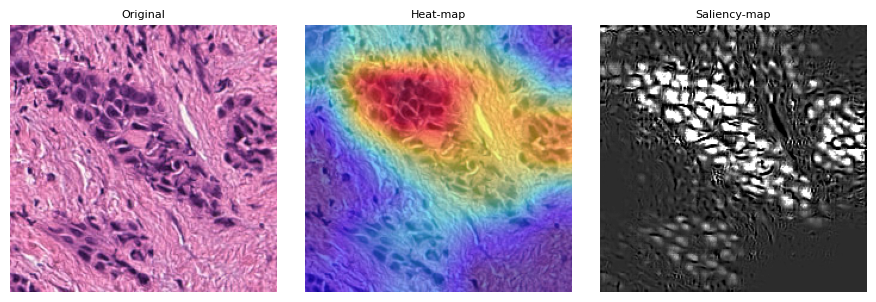

In [14]:
compute_maps(patch_dir, model)